# Parallel computing with Julia

Julia documentation link: [Parallel computing](https://docs.julialang.org/en/v1/manual/parallel-computing/index.html)

There are many types of parallelism, some of which are

* **Instruction level parallelism**
* **Multi-threading** (process shared memory)
* **Tasks aka Coroutines** aka Green threads (more like cooperative multitasking, process shared memory)
* **Multi-Core processing** (maybe system shared memory)
* **Distributed processing** (same as above but involving multiple machines)

Julia provides (more or less) native support for all of these forms of parallel processing (same order as above)

* `@simd` and [SIMD.jl](https://github.com/eschnett/SIMD.jl)
* `Base.Threads.@threads` (experimental since 2015 but seems to be fine)
* `@async`, `@sync`, `Channel`
* `@spawnat`, `@fetch`, `RemoteChannel`, `SharedArray`, etc.
* `@spawnat`, `@fetch`, `RemoteChannel`, `DArray`, `MPI.jl` etc.

With scientific computing in mind, we will mainly focus on how to distribute a process through multiple cores or machines (our thp cluster for example), that is **Multi-Core processing** and **Distributed processing**. But before we can do so, we have to learn how to control Julia's control flow through tasks.

# Tasks (Control flow)

Tasks are a control flow feature that allows computations to be suspended and resumed in a flexible manner. This feature is sometimes called by other names, such as coroutines, green or lightweight threads and cooperative multitasking.

To me, the name **cooperative multitasking** is the most descriptive. Tasks are managed/scheduled by Julia and can sometimes be run in a quasi-parallel fashion. It's no real parallel processing though. Only one task is being executed at a time.

An important use case is **asynchronous I/O**, which is typically slow. Examples are
 * **multiple user input** (Why not already process some of the input?)
 * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 * **receiving calculations from worker processes** (We'll need that below!)
 
By default, Julia will wait for every command to finish and run everything sequentially.

How do we execute commands asynchronously?

## `@async` and `@sync`

(Based on [this](https://stackoverflow.com/questions/37287020/how-and-when-to-use-async-and-sync-in-julia/37287021#37287021) stackoverflow answer.)

In [2]:
?@async

```
@async
```

Wrap an expression in a [`Task`](@ref) and add it to the local machine's scheduler queue.


What this means is that for whatever falls within its scope, Julia will start this task running but then proceed to whatever comes next in the script without waiting for the task to complete. Thus, for instance, without the macro you will get:

In [5]:
@time sleep(2);

  2.001173 seconds (50 allocations: 1.359 KiB)


But with the macro, you get:

In [10]:
@time @async sleep(2)

  0.000046 seconds (22 allocations: 2.078 KiB)


Task (runnable) @0x000000000efda290

Julia allows the script to proceed (and the `@time` macro to fully execute) without waiting for the task (in this case, sleeping for two seconds) to complete.

The `@sync` macro, by contrast, will "Wait until all dynamically-enclosed uses of `@async` [...] are complete." (see `?@sync`). 

Thus, we see:

In [11]:
@time @sync @async sleep(2)

  2.005162 seconds (1.93 k allocations: 95.940 KiB)


Task (done) @0x000000000df50b90

In this simple example then, there is no point to including a single instance of `@async` and `@sync` together. But, where `@sync` can be useful is where you have `@async` applied to multiple operations that you wish to allow to all start at once without waiting for each to complete.

In [17]:
@time @sync begin
    @async sleep(2.0)
    @async sleep(2.0)
end

  2.006509 seconds (4.46 k allocations: 216.182 KiB)


Task (done) @0x000000000df53990

In [82]:
@sync begin
    @async (sleep(2); println("Today is reverse day!"))
    @async (sleep(1); println(" class!"))
    @async print("Hello")
end;

Hello class!
Today is reverse day!


# Distributed processing: Multi-core

Distributed processing in Julia uses individual processes that communicated with each other. These processes can live on different cores and/or different hosts. Data movement and communication is explicit.

Let's focus on the *multi-core* case (your laptop/desktop) and save the cluster fun for later.

## Master-worker model

Julia uses a *master-worker* paradigm for its native distributed parallelism. One master process coordinates all the worker processes, which perform the actual computations.

By default julia starts with one process on one core. If this single process is all we have, than it is both the master and the worker.

We can change the number of processes by starting Julia with the command line option `-p X`, where the number `X` indicates how many **worker processes** we would like to have. Thus,

```
julia -p 4
```

will start Julia with 5 processes, 1 master and 4 workers.

Alternatively, we can start julia as usual (simply `julia`) and add worker processes afterwards. This is what we will do in jupyter notebooks because changing the Julia kernels startup options isn't easily possible.

In [18]:
using Distributed # Loading all tools that we need for distributed computing

In [19]:
nprocs()

1

In [26]:
nworkers() # the master is considered a worker as long as there are no real workers

1

In [21]:
addprocs(4) # I have 4 cores, so let's add 4 worker processes.

4-element Array{Int64,1}:
 2
 3
 4
 5

Every process has a Julia internal `pid`. The master is always 1. You can get the workers pids from `workers()`.

In [22]:
workers()

4-element Array{Int64,1}:
 2
 3
 4
 5

Note that the 4 worker's pids aren't necessarily 2, 3, 4 and 5. Let's remove the processes and add them once more.

In [23]:
rmprocs(workers()) # rmprocs(array of pids of worker processes to remove)

Task (done) @0x000000000ef2d9f0

In [28]:
nworkers() # only the master is left

1

In [29]:
addprocs(4)

4-element Array{Int64,1}:
 6
 7
 8
 9

In [119]:
workers()

4-element Array{Int64,1}:
 6
 7
 8
 9

## One master to rule them all - `@spawn`, `@spawnat`, `@fetch`, `@fetchfrom`, `@everywhere`...

(There are functions, like [`remotecall`](https://docs.julialang.org/en/stable/stdlib/Distributed/#Distributed.remotecall-Tuple{Any,Integer,Vararg{Any,N}%20where%20N}) and others, underlying the following macros but we'll focus on the more high-level macro usage.)

To execute commands and start computations on workers we can use the following macros

* `@spawn`: run a command or a code block on any worker and return a `Future` to it's result. It is basically `@async` for remote processes.
* `@spawnat`: same as `@spawn` but specify, `pid` as first argument, on which worker to execute the command/code block

You can look at the [documentation](https://docs.julialang.org/en/stable/manual/parallel-computing/#Multi-Core-or-Distributed-Processing-1) and their help `?@macro` for more details.

**Example:** Let's say we would like to generate a random matrix on one of the workers.

In [33]:
@spawn rand(2,2) # basically @async for remote process

Future(7, 1, 11, nothing)

In [40]:
result = @spawn rand(2,2)

Future(6, 1, 18, nothing)

In [42]:
fetch(result) # blocks similar to @sync

2×2 Array{Float64,2}:
 0.870969  0.158943
 0.245301  0.392364

Because spawning at fetching is so common, there is `@fetch` which combines both

In [49]:
@fetch rand(2,2)

2×2 Array{Float64,2}:
 0.895232  0.51967 
 0.681459  0.678942

Which worker did the work?

In [53]:
@fetch begin println(myid()); rand(2,2) end

      From worker 9:	9


2×2 Array{Float64,2}:
 0.4675    0.230163 
 0.692955  0.0518964

Using `@spawnat` and `@fetchfrom` we can delegate the work to a specific worker.

In [57]:
@fetchfrom 7 begin println(myid()); rand(2,2) end

      From worker 7:	7

2×2 Array{Float64,2}:
 0.130036  0.28039 
 0.269775  0.690673

We can use `@sync` as a blocker to wait for all workers to complete their tasks.

In [7]:
@sync begin
    pids = workers()
    @spawnat pids[1] (sleep(2); println("Today is reverse day!"))
    @spawnat pids[2] (sleep(1); println(" class!"))
    @spawnat pids[3] println("Hello")
end;
println("Done!")

      From worker 4:	Hello
      From worker 3:	 class!
      From worker 2:	Today is reverse day!
Done!


Ok, now that we understood all that, let's delegate a complicated calculation

In [ ]:
using Random

function complicated_calculation()
    sleep(1)
    randexp(5) # lives in Random
end

@fetch complicated_calculation()

**Every worker process is basically a separate julia instance.** We only defined `complicated_calculation()` on the master process. The method doesn't exist on the workers yet.

The macro `@everywhere` is useful to load packages and define methods on all processes.

In [67]:
@everywhere using Random

@everywhere function complicated_calculation()
    sleep(1)
    randexp(5) # lives in Random
end

@fetch complicated_calculation()

5-element Array{Float64,1}:
 0.11749444873005509
 0.06741375406819157
 0.6655676962992829 
 0.06850781436234352
 1.8734791096049561 

## Data movement

What is the difference between

In [85]:
function method1()
    A = rand(1000,1000)
    B = @fetch A^2
end

method1 (generic function with 1 method)

and

In [86]:
function method2()
    B = @fetch rand(1000,1000)^2
end

method2 (generic function with 1 method)

?

Let's benchmark it

In [87]:
@btime method1();
@btime method2();

  72.073 ms (128 allocations: 15.26 MiB)
  55.759 ms (116 allocations: 7.63 MiB)


Method 1 is ~30% slower, because `A` is created on the master process, transferred to a worker, squared by the worker, and finally transferred back to the master.

Method 2 creates and squares the random matrix right on the work process and only submits the result to the master.

**Data movement is crucial!**

In this toy example, the two methods are easy to distinguish and choose from. However, in a real program designing data movement might require more thought and likely some measurement. For example, if the first process needs matrix A then the first method might be better. Or, if computing A is expensive and only the current process has it, then moving it to another process might be unavoidable.

## Data movement: avoid globals (again)

In [113]:
myglobal = 4

4

In [114]:
@everywhere isdefined(Main, :myglobal) ? println("myglobal exists.") : println("Doesn't exist.")

myglobal exists.
      From worker 6:	myglobal exists.
      From worker 7:	Doesn't exist.
      From worker 8:	Doesn't exist.
      From worker 9:	Doesn't exist.


In [115]:
@fetchfrom 6 myglobal+2

6

In [116]:
@everywhere isdefined(Main, :myglobal) ? println("myglobal exists.") : println("Doesn't exist.")

myglobal exists.
      From worker 6:	myglobal exists.
      From worker 9:	Doesn't exist.
      From worker 7:	Doesn't exist.
      From worker 8:	Doesn't exist.


Globals get copied to workers and continue to exist as globals even after the call. This could lead to memory accumulation if many globals are used (just as it would in a single Julia session). Avoid them!

## Explicit data movement: `Channel` and `RemoteChannel`

Channels in Julia are a way to exchange data. They implement `put!`, `take!`, `fetch`, `isready` and `wait` methods.

In [376]:
# ?Channel

In [375]:
ch = Channel{Int}(5) # a channel that can hold up to 5 integers

Channel{Int64}(sz_max:5,sz_curr:0)

In [379]:
isready(ch) # is there something in the channel?

false

In [380]:
put!(ch, 3)

3

In [381]:
isready(ch)

true

In [382]:
take!(ch)

3

In [383]:
isready(ch)

false

In [386]:
put!(ch, 4)

4

In [390]:
fetch(ch) # basically take without a bang

4

In [394]:
take!(ch)

4

Be careful, `take!` and `put!` are blocking if the channel is empty or full!

In [396]:
isready(ch)

false

In [397]:
# take!(ch) if we would execute this, the current Julia process would hang.

## Channels for inter-process data movement: `RemoteChannel`

* A `Channel` is local to a process. Worker 2 cannot directly refer to a `Channel` on worker 3 and vice-versa.


* A `RemoteChannel`, however, can put and take values across workers. A `RemoteChannel` can be thought of as a handle to a `Channel`.


* Any process with a reference to a `RemoteChannel` can put and take items from the channel. Data is automatically sent to (or retrieved from) the process a `RemoteChannel` is associated with.


* The process id, pid, associated with a `RemoteChannel` identifies the process where the backing store, i.e., the backing Channel exists.

In [406]:
nworkers()

1

In [407]:
addprocs(4)

4-element Array{Int64,1}:
 131
 132
 133
 134

In [410]:
?RemoteChannel

search: RemoteChannel



```
RemoteChannel(pid::Integer=myid())
```

Make a reference to a `Channel{Any}(1)` on process `pid`. The default `pid` is the current process.

```
RemoteChannel(f::Function, pid::Integer=myid())
```

Create references to remote channels of a specific size and type. `f` is a function that when executed on `pid` must return an implementation of an `AbstractChannel`.

For example, `RemoteChannel(()->Channel{Int}(10), pid)`, will return a reference to a channel of type `Int` and size 10 on `pid`.

The default `pid` is the current process.


In [5]:
# creates a channel on the second worker process
# create a RemoteChannel handle to the channel on the master process
const mychannel = RemoteChannel(()->Channel{Int}(10), workers()[2])

RemoteChannel{Channel{Int64}}(3, 1, 6)

In [6]:
@everywhere try @show mychannel catch err println("Doesn't exist.") end

mychannel = RemoteChannel{Channel{Int64}}(3, 1, 6)
      From worker 3:	Doesn't exist.
      From worker 2:	Doesn't exist.
      From worker 4:	Doesn't exist.
      From worker 5:	Doesn't exist.


In [7]:
# One could create a global constant mychannel everywhere
@everywhere const mychannel = $mychannel

In [8]:
@everywhere try @show mychannel catch err println("Doesn't exist.") end

mychannel = RemoteChannel{Channel{Int64}}(3, 1, 6)
      From worker 4:	mychannel = RemoteChannel{Channel{Int64}}(3, 1, 6)
      From worker 3:	mychannel = RemoteChannel{Channel{Int64}}(3, 1, 6)
      From worker 2:	mychannel = RemoteChannel{Channel{Int64}}(3, 1, 6)
      From worker 5:	mychannel = RemoteChannel{Channel{Int64}}(3, 1, 6)


However, as we said many times before, one should generally try to avoid globals in performance critical computations.

In [9]:
function do_something()
    rc = RemoteChannel(()->Channel{Int}(10))
    @sync for p in workers()
        @spawnat p put!(rc, myid())
    end
    rc
end

r = do_something()

RemoteChannel{Channel{Int64}}(1, 1, 32)

In [10]:
isready(r)

true

In [11]:
while isready(r)
    @show take!(r)
end

take!(r) = 3
take!(r) = 5
take!(r) = 2
take!(r) = 4


## Explicit data movement: ParallelDataTransfer.jl

https://github.com/ChrisRackauckas/ParallelDataTransfer.jl/

# Helpers for common scenarios - `@distributed` and `pmap`

So far we have seen the build block of commands for distributed computing in Julia. Having scientific computing in mind, one might not always want to think about how to distribute the work and explicitly spawn tasks.

Also, fortunately, many useful parallel computations do not require (much) data movement. A common example is a direct Monte Carlo simulation, where multiple processes can handle independent simulation trials simultaneously. (We'll get to that later!)

Julia provides convenience macros to
 * Parallelize loops (`@distributed`)
 * Apply a function to all elements in some collection (`pmap`)
 
Let's explore these!

## Distributed loops (`@distributed`)

In [103]:
using Distributed, BenchmarkTools; rmprocs(workers()); addprocs(4); nworkers()

4

In [20]:
# serial version - count heads in a series of coin tosses
function add_serial(n)
    c = 0
    for i = 1:n
        c += rand(Bool)
    end
    c
end

@btime add_serial(200_000_000);

  292.159 ms (0 allocations: 0 bytes)


This is trivially parallelizable since the loop iterations are independent of each other. Many iterations can run independently over several processes, and then their results are combined, i.e. summed up. The combination process is typically called a *reduction*.

To distribute the for loop over worker processes Julia provides the `@distributed` macro:

In [16]:
?@distributed

```
@distributed
```

A distributed memory, parallel for loop of the form :

```
@distributed [reducer] for var = range
    body
end
```

The specified range is partitioned and locally executed across all workers. In case an optional reducer function is specified, `@distributed` performs local reductions on each worker with a final reduction on the calling process.

Note that without a reducer function, `@distributed` executes asynchronously, i.e. it spawns independent tasks on all available workers and returns immediately without waiting for completion. To wait for completion, prefix the call with [`@sync`](@ref), like :

```
@sync @distributed for var = range
    body
end
```


In [21]:
# distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        Int(rand(Bool))
    end
    c
end

@btime add_distributed(200_000_000);

  72.518 ms (408 allocations: 37.83 KiB)


The distributed (parallel) version is ~ 4 times as fast!

Let's see who is doing the work

In [24]:
# verbose distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        x = Int(rand(Bool))
        println(x);
        x
    end
    c
end

add_distributed(8);

      From worker 5:	1
      From worker 5:	0
      From worker 2:	1
      From worker 2:	0
      From worker 4:	0
      From worker 4:	0
      From worker 3:	0
      From worker 3:	1


The work is evenly distributed between the workers. However, by using `@distributed` we let Julia decide how to split up the work and can't control it ourselves.

A common mistake when using `@distributed` is the following:

In [40]:
function f(n)
    a = 0
    @distributed (+) for i in 1:n
        a += 1
    end
    a
end

a = f(10);

What do you expect the value of `a` to be?

In [41]:
a

0

We can (sort of) see what's happening by making everything global

In [53]:
a = 0
@distributed (+) for i in 1:10
    println("1")
    global a += 1
end;

      From worker 4:	1
      From worker 3:	1
      From worker 3:	1
      From worker 3:	1
      From worker 2:	1
      From worker 2:	1
      From worker 2:	1
      From worker 5:	1
      From worker 5:	1
      From worker 4:	1


In [57]:
@everywhere @show a

a = 0
      From worker 3:	a = 3
      From worker 5:	a = 2
      From worker 4:	a = 2
      From worker 2:	a = 3


Issue: the variable `a` gets copied to the worker processes since it is referenced in the distributed loop. Every worker will then increment its copy of `a`. Finally we do not save the result of the distributed sum but just return `a` living on the master process which hasn't been altered at all.

Corrected version:

In [44]:
function f2(n)
    a = @distributed (+) for i in 1:n
        1
    end
    a
end

a = f2(10)

10

### Distributed loop, but no reduction

The following example might not be doing what you'd expect it to. **Why?**

In [12]:
a = zeros(10)
@distributed for i = 1:10
    a[i] = i
end

Task (runnable) @0x000000000f0448b0

In [47]:
@everywhere @show a

a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 20:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0]
      From worker 19:	a = [0.0, 0.0, 0.0, 4.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0]
      From worker 21:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 10.0]
      From worker 18:	a = [1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Note that `@distributed` without a reduction function returns a `Task`. It is basically a distributed version of `@spawn` for all the iterations.

## Shared arrays (`SharedArray`)

To actually make all processes operate on the same array, one can use a `SharedArray`.

Note that `SharedArray`s can only be used if the **processes live on the same host** since they use **system shared memory** to map the same array across many processes.

The constructor of a SharedArray is

```julia
SharedArray{T,N}(dims::NTuple; init=false, pids=Int[])
```

which creates an `N`-dimensional shared array of a (bits) type `T` and size `dims` across the processes specified by `pids`.

(If an `init` function, of signature `initfn(S::SharedArray)`, is specified, it is called on all the participating workers. You can specify that each worker runs the init function on a distinct portion of the array, thereby parallelizing initialization.)

In [2]:
@everywhere using SharedArrays # has to be loaded everywhere

In [53]:
A = rand(2,3)

2×3 Array{Float64,2}:
 0.686084   0.83382   0.121731
 0.0830551  0.317622  0.595447

In [54]:
S = SharedArray(A)

2×3 SharedArray{Float64,2}:
 0.686084   0.83382   0.121731
 0.0830551  0.317622  0.595447

In [7]:
function myfill()
    S = SharedArray{Float64,2}(3,4)
    @distributed for i = 1:length(S)
        S[i] = i
    end;
    S
end

S = myfill()

3×4 SharedArray{Float64,2}:
 1.0  4.0  7.0  10.0
 2.0  5.0  8.0  11.0
 3.0  6.0  9.0  12.0

Ok, now that we know how to create and fill our `SharedArray` we can create a parallel fill function:

In [27]:
function fill_shared_problematic(N)
    S = SharedMatrix{Float64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

fill_shared_problematic(3)

3×3 SharedArray{Float64,2}:
 1.0  4.0  7.0
 2.0  5.0  8.0
 3.0  6.0  9.0

*Why is the method in its current form problematic? Try to find out yourself by going to larger `N` and, for example, inspecting the minimum of the returned `SharedArray`!*

Going to larger matrix sizes....

In [73]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

0

Note how sometimes the array isn't completely filled but still contains zeros. This is because it isn't filled **yet**!

Check again!

In [75]:
minimum(S)

1

We can use `@sync` to synchronize our distributed for loop.

In [78]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S) # added @sync here
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

1

Ok, let's **benchmark** this for a larger matrix size

In [81]:
# regular array
function fill_regular(N)
    A = Matrix{Int64}(undef,N,N)
    for i in 1:length(A)
        A[i] = i
    end
    A
end

@time fill_regular(10000);

  0.387565 seconds (12.74 k allocations: 763.594 MiB, 32.43% gc time)


In [82]:
# shared array
function fill_shared(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

@time fill_shared(10000);

  0.164206 seconds (204.49 k allocations: 10.047 MiB)


This is of course just filling an array.

If there were actual calculations it might actually be beneficial to distribute the work across workers.

## Parallel map: `pmap`

In some cases no reduction operator is needed, and we merely wish to apply a function to all integers in some range (or, more generally, to all elements in some collection). This is another useful operation called parallel map, implemented in Julia as the `pmap` function.

For example, we could compute the singular values of several large random matrices in parallel as follows:

In [9]:
@everywhere using LinearAlgebra

M = Matrix{Float64}[rand(1000,1000) for i = 1:10];

pmap(svdvals, M)

10-element Array{Array{Float64,1},1}:
 [499.847, 18.2187, 18.0436, 17.938, 17.9065, 17.7915, 17.7057, 17.6904, 17.6468, 17.575  …  0.133359, 0.125056, 0.108297, 0.0870214, 0.0781393, 0.0615988, 0.0549039, 0.0216334, 0.0165323, 0.000694651] 
 [500.502, 18.2068, 17.9437, 17.8321, 17.7877, 17.7054, 17.6529, 17.6319, 17.551, 17.5337  …  0.13807, 0.12228, 0.111597, 0.0933167, 0.0682357, 0.0543439, 0.0356474, 0.0220994, 0.0130792, 0.00315393]   
 [500.205, 18.1287, 18.0766, 18.0108, 17.9129, 17.8022, 17.7407, 17.6255, 17.5867, 17.5285  …  0.1197, 0.104309, 0.0914697, 0.0850572, 0.0808385, 0.0680347, 0.0342726, 0.0309392, 0.0154911, 0.00398373] 
 [500.136, 18.1494, 18.0249, 17.9678, 17.9219, 17.8818, 17.8046, 17.767, 17.6672, 17.5583  …  0.120724, 0.104595, 0.0950146, 0.077238, 0.0617488, 0.0540756, 0.0457184, 0.0287512, 0.0251629, 0.00291836] 
 [500.321, 18.1943, 18.017, 17.9761, 17.8797, 17.8287, 17.7642, 17.6644, 17.5708, 17.5475  …  0.121536, 0.117276, 0.102544, 0.0907997, 0.0751653, 0.06

In [110]:
# Visualize that really all of the workers participated
pmap(m->begin println(myid()); svdvals(m) end, M);

      From worker 12:	12
      From worker 11:	11
      From worker 13:	13
      From worker 10:	10
      From worker 12:	12
      From worker 10:	10
      From worker 11:	11
      From worker 13:	13
      From worker 12:	12
      From worker 11:	11


In [111]:
function svds_loop(M)
    svds = Vector{Vector{Float64}}(undef, 10)
    for (i, m) in enumerate(M)
        svds[i] = svdvals(m)
    end
    svds
end

@time svds_serial(M);
@time svdvals.(M);
@time pmap(svdvals, M);

  3.054113 seconds (105 allocations: 82.099 MiB, 2.80% gc time)
  2.904053 seconds (107 allocations: 82.099 MiB, 0.29% gc time)
  2.221958 seconds (943 allocations: 158.047 KiB)


Julia's pmap is designed for the case where each function call does a large amount of work.

In contrast, `@distributed` for can handle situations where each iteration is tiny, perhaps merely summing two numbers.

# Distributed computing: THP cluster

So far we have worked on multiple cores on a single machine, your laptop for example.

Processes can live on other machines as well! This allows for computation to scale across clusters.

In principle, the plan of action is the same as in the multi-core case. However, we have to take into account the different memory situation. In particular, we won't be able to use `SharedArray`s (as they assumed system shared memory).

In [130]:
rmprocs(workers()) # fresh start

Task (done) @0x00000000109cb0f0

## Creating workers on the cluster

Adding processes on different machines is not much harder than adding them on your local machine. In the following we will take the last example, calculating singular values of a bunch of matrices, and distribute it over multiple computers in our thp network.

In Julia, starting worker processes is handled by [ClusterManagers](https://docs.julialang.org/en/stable/manual/parallel-computing/#ClusterManagers-1).

* The default one is `LocalManager`. It is automatically used when running `addprocs(i::Integer)` and we have implicitly used it already!
* The one we are going to use for the THP cluster is `SSHManager`. It is automatically used when running `addprocs(hostnames::Array)`.

Other cluster managers for SLURM, PBS, and others are provided in [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl).

In principle, starting processes on other computers can be done by `addprocs(["l92", "l93"])`. The only requirement is a **passwordless ssh access** to all specified hosts.

*Demonstrate in terminal from thp node*

```julia
using Distributed

addprocs(["l92", "l93"])

@everywhere println(gethostname())
```

One can also start multiple processes on different machines:
```julia
addprocs([("l92", 2), ("l93", 3)]) # starts 2 workers on l92 and 3 workers on l93

# Use :auto to start as many processes as CPUs are available
```

By default, `addprocs` expects the julia executable in the same folder as on the master computer. It will also try to `cd` to the same folder.

In my case this would be

In [139]:
@show pwd();
@show Sys.BINDIR;

pwd() = "C:\\Users\\carsten\\Desktop\\sciebo\\teaching\\julia-for-physicists"
Sys.BINDIR = "C:\\Users\\carsten\\AppData\\Local\\Julia-1.0.0\\bin"


Both folders don't exist in my thp account, so I'll have to tell Julia to use different paths.

Also, as per thp cluster guidelines one **(!) must (!) run computations on other thp computer with `nice -19` priority setting**!

### Creating `nice -19` workers and specifying directories 

As you can see from `?addprocs`, `addprocs` takes a bunch of keyword arguments, two of which are of particular importance.

* `dir`: working directory of the worker process
* `exename`: path to julia executable (potentially augmented with pre-commands)

In [47]:
addprocs([("l92", :auto)], exename=`nice -19 /home/bauer/bin/julia-1.0.0/bin/julia`, dir="/home/bauer")

4-element Array{Int64,1}:
 67
 68
 69
 70

In [48]:
@everywhere println(gethostname())

l91
      From worker 67:	l92.thp.Uni-Koeln.DE
      From worker 70:	l92.thp.Uni-Koeln.DE
      From worker 69:	l92.thp.Uni-Koeln.DE
      From worker 68:	l92.thp.Uni-Koeln.DE


In [356]:
rmprocs(workers())

Task (done) @0x000000000f28c5d0

Ok, let's get some resources :)

In [355]:
machines = ["l92", "l93", "l95"];

procs_per_machine = :auto; # :auto for n = # cpus

jobs = [(m,procs_per_machine) for m in machines]

3-element Array{Tuple{String,Symbol},1}:
 ("l92", :auto)
 ("l93", :auto)
 ("l95", :auto)

In [110]:
addprocs(jobs; exename=`nice -19 /home/bauer/bin/julia-1.0.0/bin/julia`, dir="/home/bauer")

12-element Array{Int64,1}:
  99
 100
 101
 102
 103
 104
 105
 106
 107
 108
 109
 110

In [58]:
@everywhere println(gethostname())

l91
      From worker 83:	l92.thp.Uni-Koeln.DE
      From worker 84:	l95.thp.Uni-Koeln.DE
      From worker 90:	l92.thp.Uni-Koeln.DE
      From worker 89:	l92.thp.Uni-Koeln.DE
      From worker 91:	l92.thp.Uni-Koeln.DE
      From worker 85:	l93.thp.Uni-Koeln.DE
      From worker 94:	l95.thp.Uni-Koeln.DE
      From worker 92:	l95.thp.Uni-Koeln.DE
      From worker 93:	l95.thp.Uni-Koeln.DE
      From worker 87:	l93.thp.Uni-Koeln.DE
      From worker 86:	l93.thp.Uni-Koeln.DE
      From worker 88:	l93.thp.Uni-Koeln.DE


In [37]:
@everywhere using LinearAlgebra

@time pmap(svdvals, M);

 11.932196 seconds (1.22 k allocations: 488.922 KiB)


This is, of course, much slower than on a single machine because of expensive data movement.

*Use distributed arrays!*

But let's go back to using our local machine only.

## Distributed arrays (`DArray`)

Github: https://github.com/JuliaParallel/DistributedArrays.jl

In a `DArray`, each process has local access to just a chunk of the data, and no two processes share the same chunk. Processes can be on different hosts.

Distributed arrays are for example useful if

* Expensive calculations should be performed in parallel on parts of the array on different hosts.
* The data doesn't fit into the local machines memory (Loading big files in parallel).

In [111]:
@everywhere using DistributedArrays, LinearAlgebra

In [112]:
nworkers()

12

In [113]:
D = distribute(M)

10-element DArray{Array{Float64,2},1,Array{Array{Float64,2},1}}:
 [0.654804 0.427214 … 0.210974 0.81138; 0.980471 0.780448 … 0.193795 0.807734; … ; 0.129793 0.972593 … 0.0102418 0.0167808; 0.38784 0.0414453 … 0.364133 0.0902918]   
 [0.803965 0.463256 … 0.00209172 0.477335; 0.424215 0.175961 … 0.946064 0.826409; … ; 0.315962 0.00550821 … 0.0424928 0.807221; 0.562094 0.198099 … 0.335189 0.193243]
 [0.637804 0.575656 … 0.937492 0.167778; 0.545113 0.302896 … 0.968292 0.278127; … ; 0.828656 0.88628 … 0.446945 0.989451; 0.958473 0.943914 … 0.386003 0.0431498]     
 [0.581137 0.412084 … 0.737386 0.203188; 0.216486 0.633548 … 0.615498 0.0703934; … ; 0.821081 0.472846 … 0.721957 0.605373; 0.321218 0.369599 … 0.876574 0.127289]    
 [0.119343 0.415214 … 0.590712 0.634449; 0.834562 0.643564 … 0.144449 0.295535; … ; 0.488709 0.994924 … 0.762758 0.552931; 0.960707 0.0977618 … 0.398554 0.80212]     
 [0.59317 0.574452 … 0.893613 0.95359; 0.299677 0.660888 … 0.310505 0.525642; … ; 0.290564 0.0410238

Which workers hold parts of D?

In [114]:
procs(D)

10-element Array{Int64,1}:
  99
 100
 101
 102
 103
 104
 105
 106
 107
 108

Which parts do they hold?

In [115]:
localpart(D) # the master doesn't hold anything

0-element Array{Array{Float64,2},1}

In [116]:
# Which parts do they hold?
for p in workers()
    display(@fetchfrom p localpart(D))
    display(@fetchfrom p DistributedArrays.localindices(D)) # DistributedArrays. necessary because of SharedArrays above
end

1-element Array{Array{Float64,2},1}:
 [0.654804 0.427214 … 0.210974 0.81138; 0.980471 0.780448 … 0.193795 0.807734; … ; 0.129793 0.972593 … 0.0102418 0.0167808; 0.38784 0.0414453 … 0.364133 0.0902918]

(1:1,)

1-element Array{Array{Float64,2},1}:
 [0.803965 0.463256 … 0.00209172 0.477335; 0.424215 0.175961 … 0.946064 0.826409; … ; 0.315962 0.00550821 … 0.0424928 0.807221; 0.562094 0.198099 … 0.335189 0.193243]

(2:2,)

1-element Array{Array{Float64,2},1}:
 [0.637804 0.575656 … 0.937492 0.167778; 0.545113 0.302896 … 0.968292 0.278127; … ; 0.828656 0.88628 … 0.446945 0.989451; 0.958473 0.943914 … 0.386003 0.0431498]

(3:3,)

1-element Array{Array{Float64,2},1}:
 [0.581137 0.412084 … 0.737386 0.203188; 0.216486 0.633548 … 0.615498 0.0703934; … ; 0.821081 0.472846 … 0.721957 0.605373; 0.321218 0.369599 … 0.876574 0.127289]

(4:4,)

1-element Array{Array{Float64,2},1}:
 [0.119343 0.415214 … 0.590712 0.634449; 0.834562 0.643564 … 0.144449 0.295535; … ; 0.488709 0.994924 … 0.762758 0.552931; 0.960707 0.0977618 … 0.398554 0.80212]

(5:5,)

1-element Array{Array{Float64,2},1}:
 [0.59317 0.574452 … 0.893613 0.95359; 0.299677 0.660888 … 0.310505 0.525642; … ; 0.290564 0.0410238 … 0.32193 0.530886; 0.897254 0.824901 … 0.614654 0.469802]

(6:6,)

1-element Array{Array{Float64,2},1}:
 [0.968701 0.576038 … 0.341822 0.301798; 0.0649257 0.535998 … 0.169527 0.73978; … ; 0.223273 0.425356 … 0.672439 0.962274; 0.854092 0.0127202 … 0.0609207 0.0915984]

(7:7,)

1-element Array{Array{Float64,2},1}:
 [0.279128 0.922269 … 0.150039 0.945936; 0.212557 0.233853 … 0.645743 0.878176; … ; 0.114859 0.213264 … 0.606829 0.262102; 0.597363 0.680628 … 0.402748 0.536318]

(8:8,)

1-element Array{Array{Float64,2},1}:
 [0.183957 0.739774 … 0.360149 0.353599; 0.594873 0.788611 … 0.169912 0.499381; … ; 0.411664 0.99662 … 0.819771 0.713638; 0.107159 0.75321 … 0.828411 0.0979091]

(9:9,)

1-element Array{Array{Float64,2},1}:
 [0.24099 0.9736 … 0.845968 0.400483; 0.101423 0.716061 … 0.764459 0.00557274; … ; 0.0581795 0.90034 … 0.429757 0.306463; 0.17739 0.459205 … 0.100343 0.548697]

(10:10,)

0-element Array{Array{Float64,2},1}

(1:0,)

0-element Array{Array{Float64,2},1}

(1:0,)

In [117]:
@time Msquared = map(svdvals, M);

  2.724502 seconds (106 allocations: 82.099 MiB, 0.32% gc time)


In [120]:
@time Dsquared = map(svdvals, D);

  1.119496 seconds (1.62 k allocations: 145.172 KiB)


But remember, for small operations the data movement can (and will) exceed the benefit of parallelizing the computation!

In [126]:
@btime map(sum, M);
@btime map(sum, D);

  3.753 ms (2 allocations: 176 bytes)
  2.690 ms (1445 allocations: 125.56 KiB)


Other nice demonstration of distributed arrays: [Parallel loading and processing of large files](https://www.youtube.com/watch?v=euZkvgx0fG8&t=3925s)

In [128]:
# Stop worker processes!
rmprocs(workers())

Task (done) @0x00000000101a5150

# Workshop exercise - Monte Carlo calculation of π

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

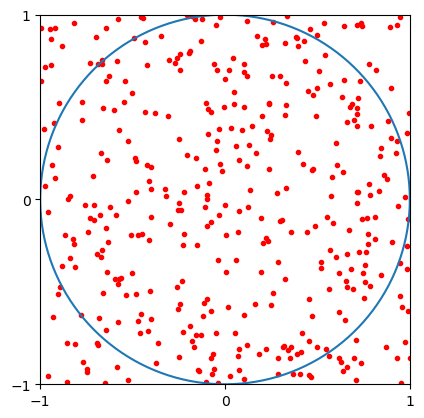

In [205]:
using PyPlot, Distributions

# plot circle
phis = range(0, stop=2*pi, step=0.01)
plot(cos.(phis), sin.(phis))

# plot darts
N = 400
d = Uniform(-1, 1)
scatter(rand(d, N), rand(d, N), marker=".", color="r")

# cosmetics
ax = gca()
ax[:set_aspect]("equal")
xlim([-1, 1])
ylim([-1, 1])
xticks([-1, 0, 1])
yticks([-1, 0, 1])
nothing

Exercise tasks:

1. Write a function `compute_pi(N::Int)` which computes $\pi$ by throwing $N$ darts as described above.


2. Based on 1), write a function `compute_pi_parallel(N::Int, nworkers::Int)` which does the same but divides the work among `ncores` processes.


3. Benchmark and compare the methods from 1) and 2).


4. Write a function `compute_pi_multiple(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The function should be serial and based on 1).


5. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which does the same but in parallel. The function should also be based on 1).


6. Benchmark and compare the methods from 4) and 5).


7. Calculate $\pi$ estimates for `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot.


8. Bonus: Write a function `compute_pi_multiple_double_parallel(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The calculation should be as parallel as possible. Multiple different values of $N$ should be calculated at the same time and every one of those calculations should be parallel as well.

A reasonable value could be `N = 10_000_000`.

In [368]:
# 1) + 3)
function compute_pi(N::Int)
    M = 0 # number of darts that landed in the circle
    for i = 1:N
        if norm(rand(2)) < 1.0
            M += 1
        end
    end

    return 4*M / N  
end

@btime compute_pi(10_000_000) # 55 s for 1 billion

  546.380 ms (10000000 allocations: 915.53 MiB)


3.1417112

In [369]:
# 2) + 3)
nworkers() == 1 ? addprocs(4) : nothing; # check if we have workers, if not add 4 of them

@everywhere using LinearAlgebra

@everywhere function compute_pi(N::Int)
    M = 0 # number of darts that landed in the circle
    for i = 1:N
        if norm(rand(2)) < 1.0
            M += 1
        end
    end

    return 4*M / N  
end

function compute_pi_parallel(N::Int, nworkers::Int)
    # distribute the dart throwing across ncores
    sum_of_pis = @distributed (+) for i=1:nworkers
        compute_pi(ceil(Int, N / nworkers))
    end

    return sum_of_pis / nworkers  # average value
end

@btime compute_pi_parallel(10_000_000, nworkers()) # 13 s for 1 billion

  135.187 ms (419 allocations: 38.14 KiB)


3.1419736

In [370]:
# 4) + 6)
function compute_pi_multiple(Ns::Vector{Int})
    pis = zeros(length(Ns))

    for i = 1:length(Ns)
        pis[i] = compute_pi(Ns[i])
    end

    return pis
end

some_Ns = [1_000_000, 10_000_000]

@btime compute_pi_multiple(some_Ns)

  621.215 ms (11000001 allocations: 1007.08 MiB)


2-element Array{Float64,1}:
 3.143816
 3.14097 

In [371]:
# 5) + 6)
nworkers() == 1 ? addprocs(4) : nothing;

@everywhere using LinearAlgebra

@everywhere function compute_pi(N::Int)
    M = 0 # number of darts that landed in the circle
    for i = 1:N
        if norm(rand(2)) < 1.0
            M += 1
        end
    end

    return 4*M / N  
end

function compute_pi_multiple_parallel(Ns::Vector{Int})
    pmap(compute_pi, Ns)
end

some_Ns = [1_000_000, 10_000_000]

@btime compute_pi_multiple_parallel($some_Ns)

  513.333 ms (213 allocations: 35.03 KiB)


2-element Array{Float64,1}:
 3.140584
 3.142516

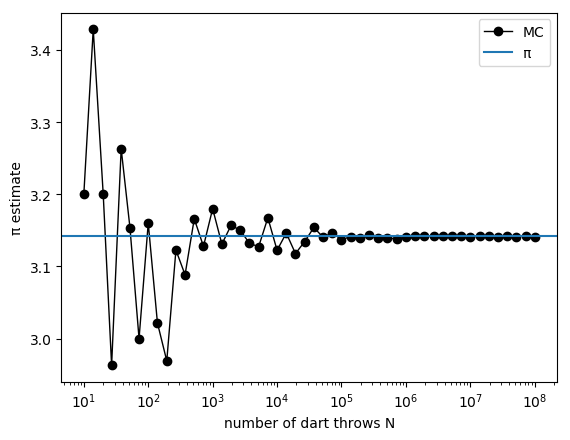

  7.855249 seconds (63.95 k allocations: 3.108 MiB)


PyObject Text(0.5,24,'number of dart throws N')

In [367]:
# 7)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))
@time pis = compute_pi_multiple_parallel(Ns)

# 4 local processes: ~ 7.8 seconds
# 12 processes @ thp cluster: ~ 4.5 seconds

semilogx(Ns, pis, "ko-", lw=1, label="MC")
axhline(y=pi, label="π")
legend()
ylabel("π estimate")
xlabel("number of dart throws N")

# If time permits....

# SIMD instructions

SIMD stands for "Single Instruction Multiple Data" and falls into the category of instruction level parallelism (vector instructions).

Example based on discussion [here](https://discourse.julialang.org/t/does-julia-use-simd-instructions-for-broadcast-operations/2492/3).

In [390]:
function square!(c::Array, x::Array)
   @assert size(c) == size(x)
   @simd for i in eachindex(x) # tells the compiler that the iterations are independent (not necessary here)
       @inbounds c[i] = x[i] * x[i]
   end
end

X = rand(Int, 1000);
Y = rand(Int, 1000);

@code_llvm square!(X, Y)


; Function square!
; Location: In[390]:2
; Function Attrs: uwtable
define nonnull %jl_value_t addrspace(10)* @"japi1_square!_37588"(%jl_value_t addrspace(10)*, %jl_value_t addrspace(10)**, i32) #0 {
top:
  %gcframe = alloca %jl_value_t addrspace(10)*, i32 3
  %3 = bitcast %jl_value_t addrspace(10)** %gcframe to i8*
  call void @llvm.memset.p0i8.i32(i8* %3, i8 0, i32 24, i32 0, i1 false)
  %4 = alloca %jl_value_t addrspace(10)**, align 8
  store volatile %jl_value_t addrspace(10)** %1, %jl_value_t addrspace(10)*** %4, align 8
  %5 = call %jl_value_t*** inttoptr (i64 1801310064 to %jl_value_t*** ()*)() #5
  %6 = getelementptr %jl_value_t addrspace(10)*, %jl_value_t addrspace(10)** %gcframe, i32 0
  %7 = bitcast %jl_value_t addrspace(10)** %6 to i64*
  store i64 2, i64* %7
  %8 = getelementptr %jl_value_t**, %jl_value_t*** %5, i32 0
  %9 = getelementptr %jl_value_t addrspace(10)*, %jl_value_t addrspace(10)** %gcframe, i32 1
  %10 = bitcast %jl_value_t addrspace(10)** %9 to %jl_value_t***

(Un)fortunately, Julia 0.7/1.0 is too clever and uses SIMD instructions automatically. This is what you would have gotten on Julia 0.6.4 without `@simd` if you didn't compile from source (binaries from the website):
```
; Function Attrs: uwtable
define void @"julia_square!_63091"(i8** dereferenceable(40), i8** dereferenceable(40)) #0 !dbg !5 {
top:
  %2 = alloca [1 x i64], align 8
  %3 = alloca [1 x i64], align 8
  %4 = call i8**** @jl_get_ptls_states() #6
  %5 = alloca [9 x i8**], align 8
  %.sub = getelementptr inbounds [9 x i8**], [9 x i8**]* %5, i64 0, i64 0
  %6 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 3
  %7 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 2
  %8 = bitcast i8*** %6 to i8*
  call void @llvm.memset.p0i8.i32(i8* %8, i8 0, i32 48, i32 8, i1 false)
  %9 = bitcast [9 x i8**]* %5 to i64*
  store i64 14, i64* %9, align 8
  %10 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 1
  %11 = bitcast i8**** %4 to i64*
  %12 = load i64, i64* %11, align 8
  %13 = bitcast i8*** %10 to i64*
  store i64 %12, i64* %13, align 8
  store i8*** %.sub, i8**** %4, align 8
  store i8** null, i8*** %7, align 8
  %14 = getelementptr i8*, i8** %0, i64 3
  %15 = bitcast i8** %14 to i64*
  %16 = load i64, i64* %15, align 8
  %17 = getelementptr inbounds [1 x i64], [1 x i64]* %3, i64 0, i64 0
  store i64 %16, i64* %17, align 8
  %18 = getelementptr i8*, i8** %1, i64 3
  %19 = bitcast i8** %18 to i64*
  %20 = load i64, i64* %19, align 8
  %21 = getelementptr inbounds [1 x i64], [1 x i64]* %2, i64 0, i64 0
  store i64 %20, i64* %21, align 8
  %22 = call i8 @"jlsys_==_40845"([1 x i64]* nocapture nonnull readonly %3, [1 x i64]* nocapture nonnull readonly %2)
  %23 = and i8 %22, 1
  %24 = icmp eq i8 %23, 0
  br i1 %24, label %L3, label %L5

L3:                                               ; preds = %top
  %25 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 7
  %26 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 5
  %27 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 4
  %28 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 8
  %29 = getelementptr [9 x i8**], [9 x i8**]* %5, i64 0, i64 6
  %30 = load i64, i64* inttoptr (i64 166019912 to i64*), align 8
  %31 = bitcast i8*** %6 to i64*
  store i64 %30, i64* %31, align 8
  store i8** inttoptr (i64 180565928 to i8**), i8*** %27, align 8
  %32 = call i8** @jl_f_getfield(i8** null, i8*** %6, i32 2)
  store i8** %32, i8*** %25, align 8
  store i8** inttoptr (i64 180570712 to i8**), i8*** %28, align 8
  %33 = call i8** @jl_f_getfield(i8** null, i8*** %25, i32 2)
  store i8** %33, i8*** %26, align 8
  store i8** inttoptr (i64 180203664 to i8**), i8*** %29, align 8
  %34 = call i8** @jl_apply_generic(i8*** %26, i32 2)
  store i8** %34, i8*** %7, align 8
  call void @jl_throw(i8** %34)
  unreachable

L5:                                               ; preds = %top
  %35 = load i64, i64* %19, align 8
  %36 = icmp slt i64 %35, 0
  %37 = select i1 %36, i64 0, i64 %35
  %38 = icmp slt i64 %37, 1
  br i1 %38, label %L66, label %if4.lr.ph.us11

if4.lr.ph.us11:                                   ; preds = %L5
  %39 = bitcast i8** %1 to i64**
  %40 = load i64*, i64** %39, align 8
  %41 = bitcast i8** %0 to i64**
  %42 = load i64*, i64** %41, align 8
  br label %if4.us12

if4.us12:                                         ; preds = %if4.us12, %if4.lr.ph.us11
  %"i#664.06.us13" = phi i64 [ 0, %if4.lr.ph.us11 ], [ %47, %if4.us12 ]
  %43 = getelementptr i64, i64* %40, i64 %"i#664.06.us13"
  %44 = load i64, i64* %43, align 8
  %45 = mul i64 %44, %44
  %46 = getelementptr i64, i64* %42, i64 %"i#664.06.us13"
  store i64 %45, i64* %46, align 8
  %47 = add nuw nsw i64 %"i#664.06.us13", 1
  %48 = icmp slt i64 %47, %37
  br i1 %48, label %if4.us12, label %L66.loopexit

L66.loopexit:                                     ; preds = %if4.us12
  br label %L66

L66:                                              ; preds = %L66.loopexit, %L5
  %49 = load i64, i64* %13, align 8
  store i64 %49, i64* %11, align 8
  ret void
}
```

**"Benchmark"**

**Julia 0.6.4 binaries (no SIMD)**

```
@btime square!($X,$Y);
  408.869 ns (0 allocations: 0 bytes)
```

**Julia 0.6.4 binaries (SIMD)**

```
@btime square!($X,$Y);
  333.155 ns (0 allocations: 0 bytes)
```

On Julia 0.6, SIMD instructions lead to ~20-25% faster code in this case.

**Julia 1.0.0 binaries (SIMD):**

In [398]:
@btime square!($X,$Y);

  197.025 ns (0 allocations: 0 bytes)


Note that due to other optimizations switching to Julia 1.0 leads to an additional ~ 60% speedup in this case.

## SIMD: Float vs Int

In [490]:
function mysum(X)
    acc = zero(eltype(X))
    for i in 1:length(X)
        @inbounds acc += X[i]
    end
    return acc
end

mysum (generic function with 1 method)

Think about if each loop iteration is independent.

Integer addition is **associative** and the order of operations has no impact. Floating-point addition is **non-associative** and the order of operations is important.

By using `@simd`, we are asserting several properties of the loop:

* It is safe to execute iterations in arbitrary or overlapping order, with special consideration for reduction variables.
* Floating-point operations on reduction variables can be reordered, possibly causing different results than without `@simd`.

In [489]:
function mysum_simd(X)
    acc = zero(eltype(X))
    @simd for i in 1:length(X)
        @inbounds acc += X[i]
    end
    return acc
end

mysum_simd (generic function with 1 method)

In [471]:
X = rand(Int64, 1000)
@btime mysum($X);
@btime mysum_simd($X);

  40.746 ns (0 allocations: 0 bytes)
  37.014 ns (0 allocations: 0 bytes)


In [469]:
X = rand(Float64, 1000)
@btime mysum($X);
@btime mysum_simd($X);

  966.125 ns (0 allocations: 0 bytes)
  67.309 ns (0 allocations: 0 bytes)


In [551]:
X = rand(Float64, 1000)
s = mysum(X);
s_simd = mysum_simd(X);

In [552]:
s == s_simd # will sometimes be false!!!

false

In [553]:
abs(s-s_simd)

1.7053025658242404e-13

# Multi-threading

On Linux/MacOS:

```bash
export JULIA_NUM_THREADS=4
```

On Windows:

```bash
set JULIA_NUM_THREADS=4
```

Afterwards start julia.

*Switching to REPL to demonstrate this...*

```julia
using Base.Threads

# How many threads are we running on?
nthreads()

# How many processes are we running?
using Distributed; nprocs()

# Fill an array in parallel
a = zeros(nthreads()*10)
@threads for i in 1:length(a)
    a[i] = threadid()
end
```

Note that we do not need to use a `SharedArray` or similar here since threads are process shared memory. Although convenient in this example, this fact can potentially lead to *thread safety* and *race condition* issues where different threads access the same piece of memory. Writing fast thread safe code isn't trivial!

See for example the sections [Atomic Operations](https://docs.julialang.org/en/stable/manual/parallel-computing/#Atomic-Operations-1) and [Side effects and mutable function arguments](https://docs.julialang.org/en/stable/manual/parallel-computing/#Side-effects-and-mutable-function-arguments-1) of the Julia documentation.

# MPI.jl

Simple wrapper to the Message Passing Interface (MPI).

Github: https://github.com/JuliaParallel/MPI.jl

Example usage:

```julia
import MPI

MPI.Init()

comm = MPI.COMM_WORLD
MPI.Barrier(comm)

root = 0
r = MPI.Comm_rank(comm)

sr = MPI.Reduce(r, MPI.SUM, root, comm)

if(MPI.Comm_rank(comm) == root)
   @printf("sum of ranks: %s\n", sr)
end

MPI.Finalize()
```

Run as
```
mpirun -np 4 ./julia example.jl
```